In this notebook, I will try to 
- Download the mnist dataset using pythons url retrieve.
- Create dataset and dataloader objects.
- Create a linear model model and train it.
- Visualize GPU usage during training.
- Visualize model parameter properties during training.

# Iteration 1: Download and train

For this iteration, I will try to create a working model as fast and minimal as I can. The only concern is to create a working model and see the loss and accuracy of my model.

## Download MNIST

In [1]:
MNIST_URL='https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true'

In [2]:
from pathlib import Path

data_path = Path("../data")
data_path.mkdir(exist_ok=True)

mnist_path = data_path / 'mnist.pkl.gz'
data_path.resolve(), mnist_path.resolve()

(PosixPath('/mnt/data/data'), PosixPath('/mnt/data/data/mnist.pkl.gz'))

In [3]:
from urllib.request import urlretrieve

if not mnist_path.exists(): urlretrieve(MNIST_URL, mnist_path)
!ls ../data

mnist.pkl  mnist.pkl.gz


## Decompress & load

In [4]:
import gzip
import shutil

mnist_pkl_path = data_path / 'mnist.pkl'

if not mnist_pkl_path.exists():
    with gzip.open(mnist_path, 'rb') as f_in:
        with open(mnist_pkl_path, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

!ls ../data

mnist.pkl  mnist.pkl.gz


In [5]:
import pickle

with open(mnist_pkl_path, 'rb') as file:
    mnist_data = pickle.load(file, encoding='latin1')

((x_train_np, y_train_np), (x_valid_np, y_valid_np), _) = mnist_data

In [6]:
import torch

torch.set_printoptions(linewidth=140)
torch.manual_seed(42)

In [7]:
x_train, y_train, x_valid, y_valid = torch.tensor(x_train_np), torch.tensor(y_train_np), torch.tensor(x_valid_np), torch.tensor(y_valid_np)
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

(torch.Size([50000, 784]),
 torch.Size([50000]),
 torch.Size([10000, 784]),
 torch.Size([10000]))

## Visualize an image

(<matplotlib.image.AxesImage at 0x7f1e91244890>, tensor(5))

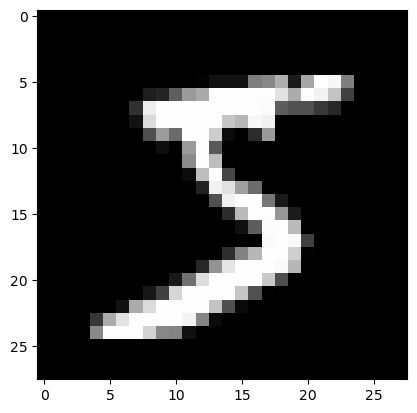

In [8]:
from matplotlib import pyplot as plt

plt.imshow(x_train[0].reshape(-1, 28), cmap='grey'), y_train[0]

## Simple linear model

In [9]:
# The model will have 28*28 input layer, no hidden layer, and 10 output layers.
# The ten outputs each will have 784 weights and one bias. So the model has 7840 + 10 parameters.

class Linear():
    def __init__(self):
        n_out = 10
        n_in = x_train.shape[1]
        self.weights = torch.rand((n_in, n_out))
        self.biases = torch.rand(n_out)

    def forward(self, xb):
        return torch.einsum('ij,jk->ik', xb, self.weights) + self.biases

In [10]:
model = Linear()
preds = model.forward(x_train[:5]); preds

tensor([[51.9183, 55.9180, 54.5348, 56.5807, 53.8507, 54.7689, 60.2444, 53.8022, 56.0413, 52.0777],
        [60.4977, 61.3303, 66.1262, 62.7357, 58.2110, 62.6643, 64.1884, 63.5394, 61.1308, 59.5316],
        [40.2522, 42.3385, 38.1412, 39.2807, 40.5282, 36.1454, 42.3355, 39.0815, 38.7224, 38.6199],
        [36.6732, 32.5491, 34.7537, 36.6066, 32.9395, 35.8008, 33.2390, 28.6313, 35.6575, 32.3496],
        [47.7470, 46.0696, 48.4084, 46.7651, 45.6137, 42.6871, 47.8302, 44.3701, 45.7667, 46.8498]])

## Softmax

In [11]:
preds = preds.exp() / preds.exp().sum(1)[:, None]; preds

tensor([[2.2732e-04, 1.2408e-02, 3.1115e-03, 2.4073e-02, 1.5700e-03, 3.9325e-03, 9.3888e-01, 1.4956e-03, 1.4036e-02, 2.6660e-04],
        [2.7546e-03, 6.3334e-03, 7.6646e-01, 2.5823e-02, 2.7988e-04, 2.4044e-02, 1.1039e-01, 5.7684e-02, 5.1881e-03, 1.0483e-03],
        [5.0909e-02, 4.1010e-01, 6.1664e-03, 1.9270e-02, 6.7092e-02, 8.3804e-04, 4.0885e-01, 1.5790e-02, 1.1027e-02, 9.9523e-03],
        [3.3918e-01, 5.4874e-03, 4.9750e-02, 3.1733e-01, 8.1077e-03, 1.4176e-01, 1.0939e-02, 1.0911e-04, 1.2284e-01, 4.4946e-03],
        [1.8902e-01, 3.5319e-02, 3.6623e-01, 7.0804e-02, 2.2389e-02, 1.1995e-03, 2.0542e-01, 6.4553e-03, 2.6090e-02, 7.7068e-02]])

In [12]:
classes = torch.arange(0, 10); classes

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

<BarContainer object of 10 artists>

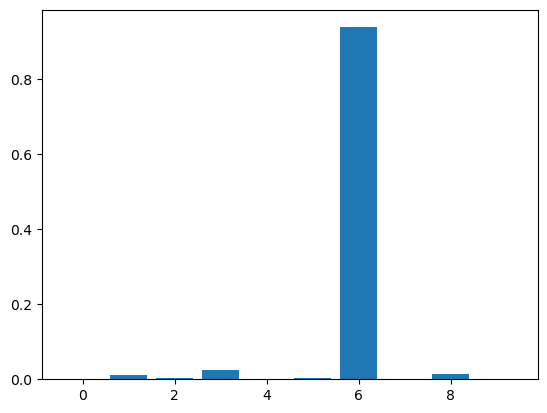

In [13]:
plt.bar(classes, preds[0])

In [14]:
import numpy as np
np.set_printoptions(linewidth=180)

In [15]:
torch.max(preds, axis=1).values[:, None]

tensor([[0.9389],
        [0.7665],
        [0.4101],
        [0.3392],
        [0.3662]])

In [16]:
def softmax(x): 
    x = x - torch.max(x, axis=1).values[:, None]
    return x.exp() / x.exp().sum(1)[:, None]

class Linear():
    def __init__(self, final_act=softmax):
        n_out = 10
        n_in = x_train.shape[1]
        self.weights = torch.rand((n_in, n_out))
        self.biases = torch.rand(n_out)
        self.final_act = final_act

    def forward(self, xb):
        return self.final_act(torch.einsum('ij,jk->ik', xb, self.weights) + self.biases)

    def train(self):
        self.weights.requires_grad_(True)
        self.biases.requires_grad_(True)
    
    def eval(self):
        self.weights.requires_grad_(False)
        self.biases.requires_grad_(False)

In [17]:
model = Linear()
preds = model.forward(x_train[:5]); preds

tensor([[6.2292e-01, 3.4908e-02, 1.7192e-02, 1.3334e-01, 1.8954e-05, 6.1609e-02, 7.2298e-02, 1.0972e-02, 4.6453e-02, 2.9067e-04],
        [4.4151e-04, 4.9165e-04, 7.5482e-02, 4.2844e-03, 1.8404e-03, 2.5274e-01, 1.0354e-02, 5.9081e-01, 9.5240e-03, 5.4040e-02],
        [3.4141e-03, 1.7066e-02, 4.2548e-02, 1.8584e-02, 1.8730e-03, 1.5841e-01, 3.8312e-01, 1.3617e-01, 3.0458e-03, 2.3577e-01],
        [3.6539e-03, 1.9475e-03, 1.8062e-04, 2.8379e-03, 8.0658e-04, 9.1254e-03, 1.5893e-01, 3.1272e-03, 1.2099e-01, 6.9841e-01],
        [4.1996e-03, 3.1849e-02, 1.9234e-03, 2.4501e-02, 6.6173e-02, 3.3356e-01, 1.1205e-02, 2.1479e-01, 3.0410e-01, 7.7073e-03]])

<BarContainer object of 10 artists>

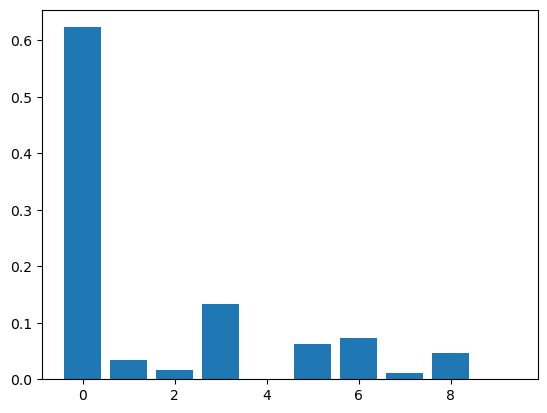

In [18]:
plt.bar(classes, preds[0])

In [19]:
from fastcore.all import *
import torch.nn.functional as F

In [20]:
test_close(F.softmax(preds, dim=1), softmax(preds))

## Loss function

In [21]:
y_train_oh = F.one_hot(y_train, num_classes=len(classes))

# should give me a big loss for 5
(y_train_oh[:5]*preds.log()).sum(1)

tensor([-2.7869, -7.7253, -6.2802, -6.2412, -4.8656])

In [22]:
# should be zero
true_pred = torch.zeros(10); true_pred[5] = 1; true_pred
y_train_oh[0]*true_pred.log()

tensor([nan, nan, nan, nan, nan, 0., nan, nan, nan, nan])

In [23]:
def ce_loss(preds, targets_oh):
    return (-targets_oh*preds.log()).sum(1)

In [24]:
ce_loss(preds, y_train_oh[:5])

tensor([2.7869, 7.7253, 6.2802, 6.2412, 4.8656])

## Training

In [25]:
torch.randn(10, 2).max(0)

torch.return_types.max(
values=tensor([1.1309, 2.8249]),
indices=tensor([7, 5]))

In [26]:
epoch = 5
lr = 0.01
bs = 64

for e in range(epoch):
    epoch_loss = 0
    for b in range(0, len(x_train) - bs, bs):
        model.train()
        xb = x_train[b:b+bs]
        preds = model.forward(xb)
        loss = ce_loss(preds, y_train_oh[b:b+bs]).mean()
        loss.backward()

        epoch_loss += loss
        
        with torch.no_grad():
            model.weights -= lr*model.weights.grad
            model.weights.grad.zero_()
            model.biases -= lr*model.biases.grad
            model.biases.grad.zero_()
        
    model.eval()
    accuracy = (model.forward(x_train).max(1).indices == y_train).float().mean().item()
    print(f'Epoch: {e+1} | Loss: {loss:.2f} | Accuracy: {accuracy:.2f}')


Epoch: 1 | Loss: 0.92 | Accuracy: 0.67
Epoch: 2 | Loss: 0.71 | Accuracy: 0.77
Epoch: 3 | Loss: 0.62 | Accuracy: 0.81
Epoch: 4 | Loss: 0.57 | Accuracy: 0.83
Epoch: 5 | Loss: 0.53 | Accuracy: 0.84


# Iteration 2: Visualise GPU usage

### Print GPU stats

In [27]:
epoch = 5
lr = 0.01
bs = 64

for e in range(epoch):
    epoch_loss = 0
    for b in range(0, len(x_train) - bs, bs):
        model.train()
        xb = x_train[b:b+bs]
        preds = model.forward(xb)
        loss = ce_loss(preds, y_train_oh[b:b+bs]).mean()
        loss.backward()

        epoch_loss += loss
        
        with torch.no_grad():
            model.weights -= lr*model.weights.grad
            model.weights.grad.zero_()
            model.biases -= lr*model.biases.grad
            model.biases.grad.zero_()
        
    model.eval()
    accuracy = (model.forward(x_train).max(1).indices == y_train).float().mean().item()
    alloc_mem = torch.cuda.memory_allocated() / 1024**2
    res_mem = torch.cuda.memory_reserved() / 1024**2
    print(f'Epoch: {e+1} | Loss: {loss:.2f} | Accuracy: {accuracy:.2f} | Allocated memory: {alloc_mem} | Cached memory: {res_mem}')


Epoch: 1 | Loss: 0.50 | Accuracy: 0.85 | Allocated memory: 0.0 | Cached memory: 0.0
Epoch: 2 | Loss: 0.48 | Accuracy: 0.86 | Allocated memory: 0.0 | Cached memory: 0.0
Epoch: 3 | Loss: 0.46 | Accuracy: 0.87 | Allocated memory: 0.0 | Cached memory: 0.0
Epoch: 4 | Loss: 0.45 | Accuracy: 0.87 | Allocated memory: 0.0 | Cached memory: 0.0
Epoch: 5 | Loss: 0.43 | Accuracy: 0.87 | Allocated memory: 0.0 | Cached memory: 0.0


### Add Tensorboard

In [28]:
from torch.utils.tensorboard import SummaryWriter

In [29]:
epoch = 5
lr = 0.01
bs = 64
writer = SummaryWriter('runs/experiment_1')

for e in range(epoch):
    epoch_loss = 0
    for b in range(0, len(x_train) - bs, bs):
        model.train()
        xb = x_train[b:b+bs]
        preds = model.forward(xb)
        loss = ce_loss(preds, y_train_oh[b:b+bs]).mean()
        loss.backward()

        epoch_loss += loss
        
        with torch.no_grad():
            model.weights -= lr*model.weights.grad
            model.weights.grad.zero_()
            model.biases -= lr*model.biases.grad
            model.biases.grad.zero_()
        
    model.eval()
    accuracy = (model.forward(x_train).max(1).indices == y_train).float().mean().item()
    alloc_mem = torch.cuda.memory_allocated() / 1024**2
    res_mem = torch.cuda.memory_reserved() / 1024**2
    print(f'Epoch: {e+1} | Loss: {loss:.2f} | Accuracy: {accuracy:.2f} | Allocated memory: {alloc_mem} Mb | Cached memory: {res_mem} Mb')
    writer.add_scalar('Loss/train', loss, e+1)
    writer.add_scalar('Accuracy/train', accuracy, e+1)        
    writer.add_scalar('GPU/Allocated Memory', alloc_mem, epoch)
    writer.add_scalar('GPU/Cached Memory', res_mem, epoch)
    
writer.close()

Epoch: 1 | Loss: 0.42 | Accuracy: 0.88 | Allocated memory: 0.0 Mb | Cached memory: 0.0 Mb
Epoch: 2 | Loss: 0.41 | Accuracy: 0.88 | Allocated memory: 0.0 Mb | Cached memory: 0.0 Mb
Epoch: 3 | Loss: 0.40 | Accuracy: 0.88 | Allocated memory: 0.0 Mb | Cached memory: 0.0 Mb
Epoch: 4 | Loss: 0.39 | Accuracy: 0.88 | Allocated memory: 0.0 Mb | Cached memory: 0.0 Mb
Epoch: 5 | Loss: 0.39 | Accuracy: 0.89 | Allocated memory: 0.0 Mb | Cached memory: 0.0 Mb


### Time each run

In [30]:
import time

epoch = 5
lr = 0.01
bs = 1024
writer = SummaryWriter('runs/experiment_1')

for e in range(epoch):
    epoch_loss = 0
    start_time = time.time()
    
    for b in range(0, len(x_train) - bs, bs):
        model.train()
        xb = x_train[b:b+bs]
        preds = model.forward(xb)
        loss = ce_loss(preds, y_train_oh[b:b+bs]).mean()
        loss.backward()

        epoch_loss += loss
        
        with torch.no_grad():
            model.weights -= lr*model.weights.grad
            model.weights.grad.zero_()
            model.biases -= lr*model.biases.grad
            model.biases.grad.zero_()
        
    model.eval()
    accuracy = (model.forward(x_train).max(1).indices == y_train).float().mean().item()
    alloc_mem = torch.cuda.memory_allocated() / 1024**2
    res_mem = torch.cuda.memory_reserved() / 1024**2
    end_time = time.time()
    dur = end_time - start_time
    print(f'Epoch: {e+1} | Time: {dur:.2f}s | Loss: {loss:.2f} | Accuracy: {accuracy:.2f} | Allocated memory: {alloc_mem} Mb | Cached memory: {res_mem} Mb')
    writer.add_scalar('Loss/train', loss, e+1)
    writer.add_scalar('Accuracy/train', accuracy, e+1)        
    writer.add_scalar('GPU/Allocated Memory', alloc_mem, epoch)
    writer.add_scalar('GPU/Cached Memory', res_mem, epoch)
    writer.add_scalar('Duration', dur, epoch)
    
writer.close()

Epoch: 1 | Time: 0.13s | Loss: 0.37 | Accuracy: 0.89 | Allocated memory: 0.0 Mb | Cached memory: 0.0 Mb
Epoch: 2 | Time: 0.13s | Loss: 0.37 | Accuracy: 0.89 | Allocated memory: 0.0 Mb | Cached memory: 0.0 Mb
Epoch: 3 | Time: 0.12s | Loss: 0.37 | Accuracy: 0.89 | Allocated memory: 0.0 Mb | Cached memory: 0.0 Mb
Epoch: 4 | Time: 0.12s | Loss: 0.37 | Accuracy: 0.89 | Allocated memory: 0.0 Mb | Cached memory: 0.0 Mb
Epoch: 5 | Time: 0.12s | Loss: 0.37 | Accuracy: 0.89 | Allocated memory: 0.0 Mb | Cached memory: 0.0 Mb


### Transfer to GPU

In [31]:
print("CUDA Available:", torch.cuda.is_available())
print("Number of GPUs:", torch.cuda.device_count())
print("Current GPU:", torch.cuda.current_device())
print("GPU Name:", torch.cuda.get_device_name(torch.cuda.current_device()))

CUDA Available: True
Number of GPUs: 1
Current GPU: 0
GPU Name: NVIDIA L4


In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [33]:
# Move the model to GPU

class Linear():
    def __init__(self, final_act=softmax):
        n_out = 10
        n_in = x_train.shape[1]
        self.weights = torch.rand((n_in, n_out)).to(device)
        self.biases = torch.rand(n_out).to(device)
        self.final_act = final_act

    def forward(self, xb):
        return self.final_act(torch.einsum('ij,jk->ik', xb, self.weights) + self.biases)

    def train(self):
        self.weights.requires_grad_(True)
        self.biases.requires_grad_(True)
    
    def eval(self):
        self.weights.requires_grad_(False)
        self.biases.requires_grad_(False)

In [34]:
model = Linear()

In [35]:
x_train = x_train.to(device)
y_train = y_train.to(device)
y_train_oh = y_train_oh.to(device)

In [36]:
import time
import pdb

epoch = 5
lr = 0.01
bs = 1024
writer = SummaryWriter('runs/experiment_2')


for e in range(epoch):
    epoch_loss = 0
    start_time = time.time()
    
    for b in range(0, len(x_train) - bs, bs):
        model.train()
        xb = x_train[b:b+bs]
        # pdb.set_trace()
        preds = model.forward(xb)
        loss = ce_loss(preds, y_train_oh[b:b+bs]).mean()
        loss.backward()

        epoch_loss += loss
        
        with torch.no_grad():
            model.weights -= lr*model.weights.grad
            model.weights.grad.zero_()
            model.biases -= lr*model.biases.grad
            model.biases.grad.zero_()
        
    model.eval()
    accuracy = (model.forward(x_train).max(1).indices == y_train).float().mean().item()
    alloc_mem = torch.cuda.memory_allocated() / 1024**2
    res_mem = torch.cuda.memory_reserved() / 1024**2
    end_time = time.time()
    dur = end_time - start_time
    print(f'Epoch: {e+1} | Time: {dur:.2f}s | Loss: {loss:.2f} | Accuracy: {accuracy:.2f} | Allocated memory: {alloc_mem:.2f} Mb | Cached memory: {res_mem:.2f} Mb')
    writer.add_scalar('Loss/train', loss, e+1)
    writer.add_scalar('Accuracy/train', accuracy, e+1)        
    writer.add_scalar('GPU/Allocated Memory', alloc_mem, epoch)
    writer.add_scalar('GPU/Cached Memory', res_mem, epoch)
    writer.add_scalar('Duration', dur, epoch)
    
writer.close()

Epoch: 1 | Time: 0.14s | Loss: 2.98 | Accuracy: 0.23 | Allocated memory: 170.55 Mb | Cached memory: 192.00 Mb
Epoch: 2 | Time: 0.04s | Loss: 2.56 | Accuracy: 0.29 | Allocated memory: 170.55 Mb | Cached memory: 192.00 Mb
Epoch: 3 | Time: 0.04s | Loss: 2.24 | Accuracy: 0.34 | Allocated memory: 170.55 Mb | Cached memory: 192.00 Mb
Epoch: 4 | Time: 0.04s | Loss: 1.99 | Accuracy: 0.40 | Allocated memory: 170.55 Mb | Cached memory: 192.00 Mb
Epoch: 5 | Time: 0.04s | Loss: 1.80 | Accuracy: 0.45 | Allocated memory: 170.55 Mb | Cached memory: 192.00 Mb


### Visualise GPU

In [37]:
import gc

def clear_gpu_memory():
    # Clear cached memory
    torch.cuda.empty_cache()
    
    # Collect garbage
    gc.collect()  # Manually trigger garbage collection

clear_gpu_memory()

Epoch: 1 | Time: 0.05s | Loss: 1.65 | Accuracy: 0.48 | Allocated memory: 170.55 Mb | Cached memory: 192.00 Mb
Epoch: 2 | Time: 0.05s | Loss: 1.52 | Accuracy: 0.52 | Allocated memory: 170.55 Mb | Cached memory: 192.00 Mb
Epoch: 3 | Time: 0.05s | Loss: 1.42 | Accuracy: 0.55 | Allocated memory: 170.55 Mb | Cached memory: 192.00 Mb
Epoch: 4 | Time: 0.05s | Loss: 1.33 | Accuracy: 0.57 | Allocated memory: 170.55 Mb | Cached memory: 192.00 Mb
Epoch: 5 | Time: 0.05s | Loss: 1.26 | Accuracy: 0.59 | Allocated memory: 170.55 Mb | Cached memory: 192.00 Mb


Text(0.5, 1.0, 'GPU Cache (Reserved) Memory')

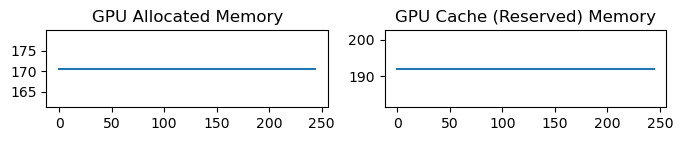

In [38]:
import time
import pdb

epoch = 5
lr = 0.01
bs = 1024
writer = SummaryWriter('runs/experiment_2')
gpu_alloc = []
gpu_res = []


for e in range(epoch):
    epoch_loss = 0
    start_time = time.time()
    
    for b in range(0, len(x_train) - bs, bs):
        model.train()
        xb = x_train[b:b+bs]
        # pdb.set_trace()
        preds = model.forward(xb)
        loss = ce_loss(preds, y_train_oh[b:b+bs]).mean()
        loss.backward()

        epoch_loss += loss

        gpu_alloc.append(torch.cuda.memory_allocated() / 1024**2)
        gpu_res.append(torch.cuda.memory_reserved() / 1024**2)
        
        with torch.no_grad():
            model.weights -= lr*model.weights.grad
            model.weights.grad.zero_()
            model.biases -= lr*model.biases.grad
            model.biases.grad.zero_()
        
    model.eval()
    accuracy = (model.forward(x_train).max(1).indices == y_train).float().mean().item()
    alloc_mem = torch.cuda.memory_allocated() / 1024**2
    gpu_alloc.append(alloc_mem)
    res_mem = torch.cuda.memory_reserved() / 1024**2
    gpu_res.append(res_mem)
    end_time = time.time()
    dur = end_time - start_time
    print(f'Epoch: {e+1} | Time: {dur:.2f}s | Loss: {loss:.2f} | Accuracy: {accuracy:.2f} | Allocated memory: {alloc_mem:.2f} Mb | Cached memory: {res_mem:.2f} Mb')
    writer.add_scalar('Loss/train', loss, e+1)
    writer.add_scalar('Accuracy/train', accuracy, e+1)        
    writer.add_scalar('GPU/Allocated Memory', alloc_mem, epoch)
    writer.add_scalar('GPU/Cached Memory', res_mem, epoch)
    writer.add_scalar('Duration', dur, epoch)
    
writer.close()
fig, ax = plt.subplots(1, 2, figsize=(8,1))
ax[0].plot(torch.arange(len(gpu_alloc)), gpu_alloc)
ax[0].set_title("GPU Allocated Memory")

ax[1].plot(torch.arange(len(gpu_res)), gpu_res)
ax[1].set_title("GPU Cache (Reserved) Memory")

# Iteration 3: Datasets and Dataloaders

In this iteration, I will create datasets and dataloaders for training and validation.

### Datasets

In [39]:
import pickle
import shutil
from urllib.request import urlretrieve
from pathlib import Path
import gzip
import torch

class MNISTDataset():
    def __init__(self, path="../data", test=False, device=device):
        MNIST_URL='https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true'
        data_path = Path(path)
        data_path.mkdir(exist_ok=True)
        gz_path = data_path / "mnist.pkl.gz"
        if not gz_path.exists(): urlretrieve(MNIST_URL, gz_path)
        pkl_path = data_path / "mnist.pkl"
        if not pkl_path.exists():
            with gzip.open(gz_path, 'rb') as f_in:
                with open(pkl_path, 'wb') as f_out:
                    shutil.copyfileobj(f_in, f_out)
        with open(pkl_path, 'rb') as file:
            mnist_data = pickle.load(file, encoding="latin1")
        self.indep = torch.tensor(mnist_data[1 if test else 0][0], device=device)
        self.dep = torch.tensor(mnist_data[1 if test else 0][1], device=device)

    def __len__(self):
        return len(self.indep)

    def __getitem__(self, i):
        return self.indep[i], self.dep[i]

    def show(self, i, ax=None):
        if ax is None: _, ax = plt.subplots()
        indep, dep = self[i]
        ax.imshow(indep.view(28, 28).cpu(), cmap='grey')
        ax.set_title(dep.item())
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])

In [40]:
train_ds = MNISTDataset()
val_ds = MNISTDataset(test=True)

train_ds[0][0].shape, train_ds[0][1].shape, val_ds[0][0].shape, val_ds[0][1]

(torch.Size([784]),
 torch.Size([]),
 torch.Size([784]),
 tensor(3, device='cuda:0'))

(None, None)

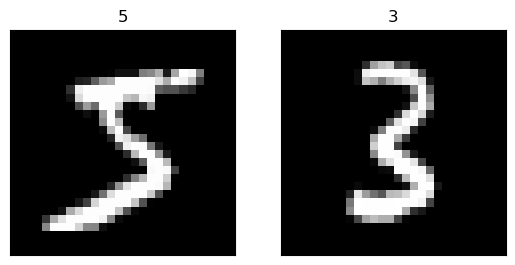

In [41]:
_, ax = plt.subplots(1, 2)
train_ds.show(0, ax[0]), val_ds.show(0, ax[1])

## Data Loaders

In [42]:
import math

class DataLoader():
    def __init__(self, dataset, bs=64, shuffle=False, device=device):
        self.dataset = dataset
        self.batch_size = bs
        self.shuffle = shuffle
        self.current_index = 0
        self.indices = np.arange(len(dataset))
        self.device = device

    def __iter__(self):
        self.current_index = 0
        if self.shuffle: np.random.shuffle(self.indices)
        return self
    
    def __next__(self):
        start_index = self.current_index
        if start_index >= len(self.dataset): raise StopIteration
        end_index = min(start_index + self.batch_size, len(self.dataset))
        self.current_index = end_index
        batch = self.dataset[self.indices[start_index:end_index]]
        return batch[0].to(device), batch[1].to(device)
        
    def __getitem__(self, i):
        start_index = i * self.batch_size
        if start_index >= len(self.dataset): raise Error("dataset out of bounds")
        end_index = min(start_index + self.batch_size, len(self.dataset))
        batch = self.dataset[self.indices[start_index:end_index]]
        return batch[0].to(device), batch[1].to(device)

    def show(self, n=16):
        cols = 4
        rows = math.ceil(n/cols)
        _, ax = plt.subplots(rows, cols, figsize=(10,5))
        for i in self.indices[:n]:
            self.dataset.show(i, ax[i//cols][i%cols])
            

In [43]:
train_dl = DataLoader(train_ds, bs=1024, shuffle=True)
val_dl = DataLoader(val_ds, bs=64)
xb, yb = train_dl[0]
xb.shape, yb.shape

(torch.Size([1024, 784]), torch.Size([1024]))

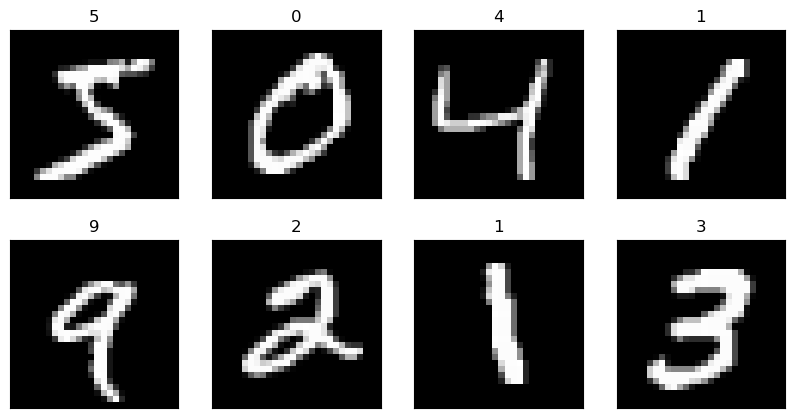

In [44]:
train_dl.show(8)

## Training loop with DL

In [45]:
def ce_loss2(preds, targets):
    # pdb.set_trace()
    targets_oh = F.one_hot(targets, 10)
    return (-targets_oh*preds.log()).sum(1)

In [46]:
ce_loss2(torch.rand(64, 10), torch.randint(0, 10, (64,)))

tensor([1.4287, 1.2575, 0.3973, 0.4307, 0.1691, 1.7252, 1.3746, 0.4546, 0.4836, 1.2703, 1.3048, 0.8459, 1.0793, 0.2916, 2.2175, 0.0421,
        0.9361, 1.5482, 0.8416, 0.3169, 1.3357, 2.0081, 2.6157, 1.7166, 1.5025, 6.1137, 1.1619, 2.1986, 0.6656, 1.3682, 0.2926, 2.5997,
        0.6617, 0.9071, 0.9643, 0.5970, 0.8351, 0.2553, 0.1637, 1.7610, 0.0973, 0.6883, 0.3975, 0.7412, 0.0681, 0.3681, 0.3261, 1.9145,
        0.1354, 0.5525, 0.0315, 1.7082, 0.1292, 0.3377, 0.1781, 0.7422, 0.4449, 2.5627, 0.1788, 1.0423, 0.2919, 1.8502, 1.3646, 0.7277])

Epoch: 1 | Time: 0.06s | Loss: 1.23 | Accuracy: 0.59 | Allocated memory: 353.54 Mb | Cached memory: 372.00 Mb
Epoch: 2 | Time: 0.05s | Loss: 1.21 | Accuracy: 0.60 | Allocated memory: 354.07 Mb | Cached memory: 372.00 Mb
Epoch: 3 | Time: 0.05s | Loss: 1.10 | Accuracy: 0.65 | Allocated memory: 353.54 Mb | Cached memory: 372.00 Mb
Epoch: 4 | Time: 0.05s | Loss: 0.97 | Accuracy: 0.65 | Allocated memory: 354.07 Mb | Cached memory: 372.00 Mb
Epoch: 5 | Time: 0.05s | Loss: 0.96 | Accuracy: 0.67 | Allocated memory: 353.54 Mb | Cached memory: 372.00 Mb


Text(0.5, 1.0, 'GPU Cache (Reserved) Memory')

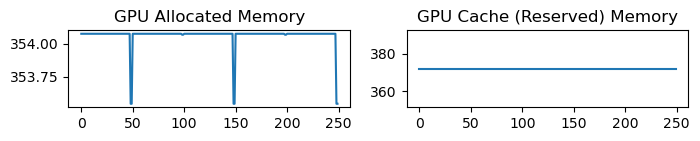

In [47]:
import time
import pdb

epoch = 5
lr = 0.01
bs = 1024
writer = SummaryWriter('runs/experiment_3')
gpu_alloc = []
gpu_res = []


for e in range(epoch):
    epoch_loss = 0
    start_time = time.time()
    
    model.train()
    for xb, yb in train_dl:
        preds = model.forward(xb)
        loss = ce_loss2(preds, yb).mean()
        loss.backward()

        epoch_loss += loss

        gpu_alloc.append(torch.cuda.memory_allocated() / 1024**2)
        gpu_res.append(torch.cuda.memory_reserved() / 1024**2)
        
        with torch.no_grad():
            model.weights -= lr*model.weights.grad
            model.weights.grad.zero_()
            model.biases -= lr*model.biases.grad
            model.biases.grad.zero_()
        
    model.eval()
    accuracy = (model.forward(xb).max(1).indices == yb).float().mean().item()
    alloc_mem = torch.cuda.memory_allocated() / 1024**2
    gpu_alloc.append(alloc_mem)
    res_mem = torch.cuda.memory_reserved() / 1024**2
    gpu_res.append(res_mem)
    end_time = time.time()
    dur = end_time - start_time
    print(f'Epoch: {e+1} | Time: {dur:.2f}s | Loss: {loss:.2f} | Accuracy: {accuracy:.2f} | Allocated memory: {alloc_mem:.2f} Mb | Cached memory: {res_mem:.2f} Mb')
    writer.add_scalar('Loss/train', loss, e+1)
    writer.add_scalar('Accuracy/train', accuracy, e+1)        
    writer.add_scalar('GPU/Allocated Memory', alloc_mem, epoch)
    writer.add_scalar('GPU/Cached Memory', res_mem, epoch)
    writer.add_scalar('Duration', dur, epoch)
    
writer.close()
fig, ax = plt.subplots(1, 2, figsize=(8,1))
ax[0].plot(torch.arange(len(gpu_alloc)), gpu_alloc)
ax[0].set_title("GPU Allocated Memory")

ax[1].plot(torch.arange(len(gpu_res)), gpu_res)
ax[1].set_title("GPU Cache (Reserved) Memory")

# Iteration 4: Validation sets

In [48]:
class DataLoaders():
    def __init__(self, train_dataset, test_dataset, bs=64, shuffle=False, device=device):
        self.train = DataLoader(train_dataset, bs=bs, shuffle=shuffle, device=device)
        self.test = DataLoader(test_dataset, bs=bs, shuffle=False, device=device)

    def __iter__(self):
        self.train_iter = iter(self.train)
        return self.train_iter
    
    def __next__(self):
        return next(self.train_iter)
        
    def __getitem__(self, i):
        return self.train.__getitem__(i)

    def show(self, n=16):
        self.train.show(n)

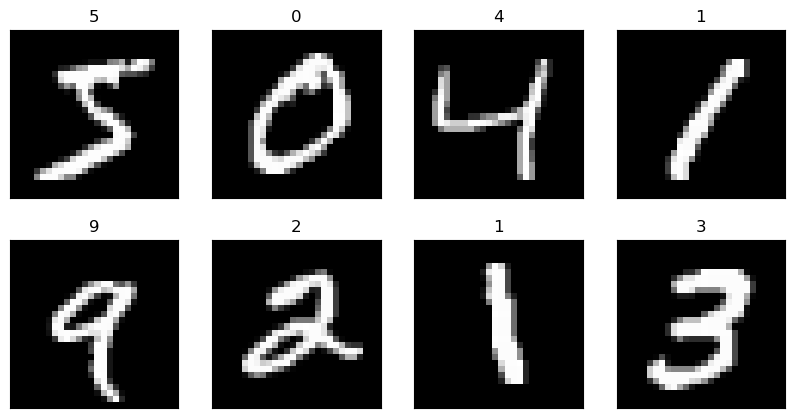

In [49]:
dls = DataLoaders(train_ds, val_ds, bs=1024, shuffle=True, device=device)
dls.show(8)

Epoch: 1 | Time: 0.06s | Loss: 0.80 | Valid loss: 0.72 | Accuracy: 0.77 | Allocated memory: 354.45 Mb | Cached memory: 374.00 Mb
Epoch: 2 | Time: 0.06s | Loss: 0.67 | Valid loss: 0.62 | Accuracy: 0.81 | Allocated memory: 353.93 Mb | Cached memory: 374.00 Mb
Epoch: 3 | Time: 0.06s | Loss: 0.64 | Valid loss: 0.56 | Accuracy: 0.83 | Allocated memory: 354.45 Mb | Cached memory: 374.00 Mb
Epoch: 4 | Time: 0.05s | Loss: 0.58 | Valid loss: 0.52 | Accuracy: 0.84 | Allocated memory: 353.93 Mb | Cached memory: 374.00 Mb
Epoch: 5 | Time: 0.06s | Loss: 0.61 | Valid loss: 0.49 | Accuracy: 0.85 | Allocated memory: 354.45 Mb | Cached memory: 376.00 Mb
Epoch: 6 | Time: 0.06s | Loss: 0.53 | Valid loss: 0.47 | Accuracy: 0.86 | Allocated memory: 353.93 Mb | Cached memory: 376.00 Mb
Epoch: 7 | Time: 0.05s | Loss: 0.52 | Valid loss: 0.45 | Accuracy: 0.86 | Allocated memory: 354.45 Mb | Cached memory: 376.00 Mb
Epoch: 8 | Time: 0.05s | Loss: 0.55 | Valid loss: 0.44 | Accuracy: 0.87 | Allocated memory: 353.9

Text(0.5, 1.0, 'GPU Cache (Reserved) Memory')

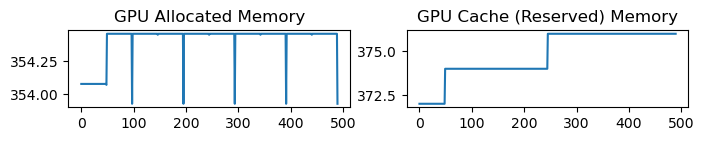

In [50]:
import time
import pdb

epoch = 10
lr = 0.1
writer = SummaryWriter('runs/experiment_3')
gpu_alloc = []
gpu_res = []


for e in range(epoch):
    epoch_loss = 0
    start_time = time.time()
    
    model.train()
    for xb, yb in dls:
        preds = model.forward(xb)
        loss = ce_loss2(preds, yb).mean()
        loss.backward()

        epoch_loss += loss

        gpu_alloc.append(torch.cuda.memory_allocated() / 1024**2)
        gpu_res.append(torch.cuda.memory_reserved() / 1024**2)
        
        with torch.no_grad():
            model.weights -= lr*model.weights.grad
            model.weights.grad.zero_()
            model.biases -= lr*model.biases.grad
            model.biases.grad.zero_()
        
    model.eval()
    
    val_x, val_y = dls.test.dataset[:]
    val_preds = model.forward(val_x)
    val_loss = ce_loss2(val_preds, val_y).mean()
    accuracy = (val_preds.max(1).indices == val_y).float().mean().item()
    
    alloc_mem = torch.cuda.memory_allocated() / 1024**2
    res_mem = torch.cuda.memory_reserved() / 1024**2
    
    end_time = time.time()
    dur = end_time - start_time
    
    print(f'Epoch: {e+1} | Time: {dur:.2f}s | Loss: {loss:.2f} | Valid loss: {val_loss:.2f} | Accuracy: {accuracy:.2f} | Allocated memory: {alloc_mem:.2f} Mb | Cached memory: {res_mem:.2f} Mb')
    
    writer.add_scalar('Loss/train', loss, e+1)
    writer.add_scalar('Accuracy/train', accuracy, e+1)        
    writer.add_scalar('GPU/Allocated Memory', alloc_mem, epoch)
    writer.add_scalar('GPU/Cached Memory', res_mem, epoch)
    writer.add_scalar('Duration', dur, epoch)
    
writer.close()
fig, ax = plt.subplots(1, 2, figsize=(8,1))
ax[0].plot(torch.arange(len(gpu_alloc)), gpu_alloc)
ax[0].set_title("GPU Allocated Memory")

ax[1].plot(torch.arange(len(gpu_res)), gpu_res)
ax[1].set_title("GPU Cache (Reserved) Memory")

# Iteration 5: Optimisers

In [51]:
class SGDOptimiser():
    def __init__(self, model, lr):
        self.model = model
        self.lr = lr

    def step(self):
        with torch.no_grad():
            self.model.weights -= self.model.weights.grad*self.lr
            self.model.biases -= self.model.biases.grad*self.lr

    def zero(self):
        with torch.no_grad():
            self.model.weights.grad.zero_()
            self.model.biases.grad.zero_()

Epoch: 1 | Time: 0.06s | Train Loss: 0.45 | Valid loss: 0.41 | Accuracy: 0.88 | Allocated memory: 354.45 Mb | Cached memory: 376.00 Mb
Epoch: 2 | Time: 0.06s | Train Loss: 0.45 | Valid loss: 0.40 | Accuracy: 0.88 | Allocated memory: 353.93 Mb | Cached memory: 376.00 Mb
Epoch: 3 | Time: 0.06s | Train Loss: 0.43 | Valid loss: 0.40 | Accuracy: 0.88 | Allocated memory: 354.45 Mb | Cached memory: 376.00 Mb
Epoch: 4 | Time: 0.06s | Train Loss: 0.39 | Valid loss: 0.39 | Accuracy: 0.89 | Allocated memory: 353.93 Mb | Cached memory: 376.00 Mb
Epoch: 5 | Time: 0.06s | Train Loss: 0.44 | Valid loss: 0.38 | Accuracy: 0.89 | Allocated memory: 354.45 Mb | Cached memory: 376.00 Mb
Epoch: 6 | Time: 0.05s | Train Loss: 0.44 | Valid loss: 0.38 | Accuracy: 0.89 | Allocated memory: 353.93 Mb | Cached memory: 376.00 Mb
Epoch: 7 | Time: 0.06s | Train Loss: 0.46 | Valid loss: 0.38 | Accuracy: 0.89 | Allocated memory: 354.45 Mb | Cached memory: 376.00 Mb
Epoch: 8 | Time: 0.05s | Train Loss: 0.40 | Valid loss:

Text(0.5, 1.0, 'GPU Cache (Reserved) Memory')

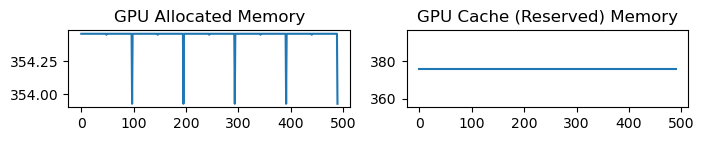

In [52]:
import time
import pdb

epoch = 10
lr = 0.1
writer = SummaryWriter('runs/experiment_3')
gpu_alloc = []
gpu_res = []
sgd_optim = SGDOptimiser(model, lr)

for e in range(epoch):
    epoch_loss = 0
    start_time = time.time()
    
    model.train()
    for xb, yb in dls:
        preds = model.forward(xb)
        loss = ce_loss2(preds, yb).mean()
        loss.backward()

        epoch_loss += loss

        gpu_alloc.append(torch.cuda.memory_allocated() / 1024**2)
        gpu_res.append(torch.cuda.memory_reserved() / 1024**2)
        
        sgd_optim.step()
        sgd_optim.zero()
        
    model.eval()
    
    val_x, val_y = dls.test.dataset[:]
    val_preds = model.forward(val_x)
    val_loss = ce_loss2(val_preds, val_y).mean()
    accuracy = (val_preds.max(1).indices == val_y).float().mean().item()
    
    alloc_mem = torch.cuda.memory_allocated() / 1024**2
    res_mem = torch.cuda.memory_reserved() / 1024**2
    
    end_time = time.time()
    dur = end_time - start_time
    
    print(f'Epoch: {e+1} | Time: {dur:.2f}s | Train Loss: {loss:.2f} | Valid loss: {val_loss:.2f} | Accuracy: {accuracy:.2f} | Allocated memory: {alloc_mem:.2f} Mb | Cached memory: {res_mem:.2f} Mb')
    
    writer.add_scalar('Loss/train', loss, e+1)
    writer.add_scalar('Accuracy/train', accuracy, e+1)        
    writer.add_scalar('GPU/Allocated Memory', alloc_mem, epoch)
    writer.add_scalar('GPU/Cached Memory', res_mem, epoch)
    writer.add_scalar('Duration', dur, epoch)
    
writer.close()
fig, ax = plt.subplots(1, 2, figsize=(8,1))
ax[0].plot(torch.arange(len(gpu_alloc)), gpu_alloc)
ax[0].set_title("GPU Allocated Memory")

ax[1].plot(torch.arange(len(gpu_res)), gpu_res)
ax[1].set_title("GPU Cache (Reserved) Memory")

# Iteration 6: Learner and Callbacks

In [53]:
class Learner():
    def __init__(self, model, optim, loss_fn, dls):
        self.model = model
        self.optim = optim
        self.loss_fn = loss_fn
        self.dls = dls
        
    def fit(self, epoch):
        gpu_alloc = []
        gpu_res = []
        
        for e in range(epoch):
            epoch_loss = 0
            start_time = time.time()
            
            self.model.train()
            for xb, yb in self.dls:
                preds = self.model.forward(xb)
                loss = self.loss_fn(preds, yb).mean()
                loss.backward()
        
                epoch_loss += loss
        
                gpu_alloc.append(torch.cuda.memory_allocated() / 1024**2)
                gpu_res.append(torch.cuda.memory_reserved() / 1024**2)
                
                self.optim.step()
                self.optim.zero()
                
            self.model.eval()
            
            val_x, val_y = self.dls.test.dataset[:]
            val_preds = self.model.forward(val_x)
            val_loss = self.loss_fn(val_preds, val_y).mean()
            accuracy = (val_preds.max(1).indices == val_y).float().mean().item()
            
            alloc_mem = torch.cuda.memory_allocated() / 1024**2
            res_mem = torch.cuda.memory_reserved() / 1024**2
            
            end_time = time.time()
            dur = end_time - start_time
            
            print(f'Epoch: {e+1} | Time: {dur:.2f}s | Train Loss: {loss:.2f} | Valid loss: {val_loss:.2f} | Accuracy: {accuracy:.2f} | Allocated memory: {alloc_mem:.2f} Mb | Cached memory: {res_mem:.2f} Mb')
            
        fig, ax = plt.subplots(1, 2, figsize=(8,1))
        ax[0].plot(torch.arange(len(gpu_alloc)), gpu_alloc)
        ax[0].set_title("GPU Allocated Memory")
        
        ax[1].plot(torch.arange(len(gpu_res)), gpu_res)
        ax[1].set_title("GPU Cache (Reserved) Memory")

Epoch: 1 | Time: 0.05s | Train Loss: 0.40 | Valid loss: 0.36 | Accuracy: 0.90 | Allocated memory: 357.41 Mb | Cached memory: 376.00 Mb
Epoch: 2 | Time: 0.05s | Train Loss: 0.37 | Valid loss: 0.36 | Accuracy: 0.90 | Allocated memory: 356.88 Mb | Cached memory: 376.00 Mb
Epoch: 3 | Time: 0.06s | Train Loss: 0.39 | Valid loss: 0.35 | Accuracy: 0.90 | Allocated memory: 357.41 Mb | Cached memory: 376.00 Mb
Epoch: 4 | Time: 0.05s | Train Loss: 0.42 | Valid loss: 0.35 | Accuracy: 0.90 | Allocated memory: 356.88 Mb | Cached memory: 376.00 Mb
Epoch: 5 | Time: 0.06s | Train Loss: 0.36 | Valid loss: 0.35 | Accuracy: 0.90 | Allocated memory: 357.41 Mb | Cached memory: 376.00 Mb


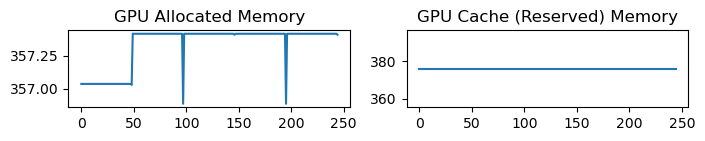

In [54]:
learner = Learner(model=model, optim=sgd_optim, loss_fn=ce_loss2, dls=dls)
learner.fit(5)

## Callbacks

In [55]:
class Learner_2():
    def __init__(self, model, optim, loss_fn, dls, cbs):
        self.model = model
        self.optim = optim
        self.loss_fn = loss_fn
        self.dls = dls
        self.cbs = cbs
        self.epoch = None
        self.current_epoch = None
        self.current_batch = None
        self.epoch_loss = None
        self.batch_loss = None
        self.val_loss = None

    def _cb(self, cb_name):
        for cb in self.cbs:
            cb_fn = getattr(cb, cb_name, None)
            if cb_fn is not None: cb_fn(self)
        
    def fit(self, epoch):
        self.epoch = epoch
        self._cb("before_fit")
        
        for self.current_epoch in range(epoch):
            self._cb("before_epoch")
            self.epoch_loss = 0
            
            self.model.train()
            for xb, yb in self.dls:
                self.current_batch = (xb, yb)
                self._cb("before_batch")
                preds = self.model.forward(xb)
                self.batch_loss = self.loss_fn(preds, yb).mean()
                self.batch_loss.backward()
        
                self.epoch_loss += loss
                
                self.optim.step()
                self.optim.zero()
                self._cb("after_batch")
            
            self.model.eval()
            
            val_x, val_y = self.dls.test.dataset[:]
            val_preds = self.model.forward(val_x)
            self.val_loss = self.loss_fn(val_preds, val_y).mean()
            accuracy = (val_preds.max(1).indices == val_y).float().mean().item()
            self._cb("after_epoch")
        self._cb("after_fit")

In [56]:
class GPUStatsCb:
    alloc_mem = []
    cache_mem = []

    def after_batch(self, learner):
        self.alloc_mem.append(torch.cuda.memory_allocated() / 1024**2)
        self.cache_mem.append(torch.cuda.memory_reserved() / 1024**2)

    def after_fit(self, learner):
        fig, ax = plt.subplots(1, 2, figsize=(8,1))
        ax[0].plot(torch.arange(len(gpu_alloc)), gpu_alloc)
        ax[0].set_title("GPU Allocated Memory")
        ax[1].plot(torch.arange(len(gpu_res)), gpu_res)
        ax[1].set_title("GPU Cache (Reserved) Memory")

In [57]:
class ProgressCb:
    start_time
    end_time
    
    def __init__(self, gpu_stats):
        self.gpu = gpu_stats

    def before_epoch(self, learner):
        self.start_time = time.time()

    def after_epoch(self, learner):
        self.end_time = time.time()
        dur = self.end_time - self.start_time
        print(f'Epoch: {learner.current_epoch+1} | Time: {dur:.2f}s | Train Loss: {learner.epoch_loss:.2f} | Valid loss: {learner.val_loss:.2f} | Allocated memory: {self.gpu.alloc_mem[-1]:.2f} Mb | Cached memory: {self.gpu.cache_mem[-1]:.2f} Mb')

Epoch: 1 | Time: 0.06s | Train Loss: 19.56 | Valid loss: 0.35 | Allocated memory: 357.03 Mb | Cached memory: 376.00 Mb
Epoch: 2 | Time: 0.06s | Train Loss: 19.56 | Valid loss: 0.35 | Allocated memory: 356.88 Mb | Cached memory: 376.00 Mb
Epoch: 3 | Time: 0.06s | Train Loss: 19.56 | Valid loss: 0.34 | Allocated memory: 357.41 Mb | Cached memory: 376.00 Mb
Epoch: 4 | Time: 0.06s | Train Loss: 19.56 | Valid loss: 0.34 | Allocated memory: 356.88 Mb | Cached memory: 376.00 Mb
Epoch: 5 | Time: 0.05s | Train Loss: 19.56 | Valid loss: 0.34 | Allocated memory: 357.41 Mb | Cached memory: 376.00 Mb


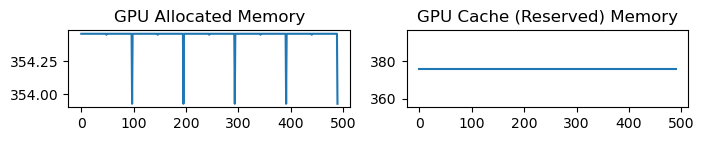

In [58]:
gpu_stats_cb = GPUStatsCb()
learner_2 = Learner_2(model=model, optim=sgd_optim, dls=dls, loss_fn=ce_loss2, cbs=[gpu_stats_cb, ProgressCb(gpu_stats_cb)])
learner_2.fit(5)

# Iteration 7: Metrics Cb

In [59]:
class Learner_3():
    def __init__(self, model, optim, loss_fn, dls, cbs):
        self.model = model
        self.optim = optim
        self.loss_fn = loss_fn
        self.dls = dls
        self.cbs = cbs
        self.epoch = None
        self.current_epoch = None
        self.current_batch = None
        self.epoch_loss = None
        self.batch_loss = None
        self.val_loss = None
        self.val_preds = None

    def _cb(self, cb_name):
        for cb in self.cbs:
            cb_fn = getattr(cb, cb_name, None)
            if cb_fn is not None: cb_fn(self)
        
    def fit(self, epoch):
        self.epoch = epoch
        self._cb("before_fit")
        
        for self.current_epoch in range(epoch):
            self._cb("before_epoch")
            self.epoch_loss = 0
            
            self.model.train()
            for xb, yb in self.dls:
                self.current_batch = (xb, yb)
                self._cb("before_batch")
                preds = self.model.forward(xb)
                self.batch_loss = self.loss_fn(preds, yb).mean()
                self.batch_loss.backward()
        
                self.epoch_loss += loss
                
                self.optim.step()
                self.optim.zero()
                self._cb("after_batch")

            self.model.eval()
            
            val_x, val_y = self.dls.test.dataset[:]
            self.val_preds = self.model.forward(val_x)
            self.val_loss = self.loss_fn(val_preds, val_y).mean()
            self._cb("after_epoch")
        self._cb("after_fit")

In [60]:
class AccuracyCb:
    metric = None
    name = "Accuracy"
    def after_epoch(self, learner):
        self.metric = (learner.val_preds.max(1).indices == learner.dls.test.dataset[:][1]).float().mean().item()
        

In [61]:
class ProgressCb_2:
    start_time
    end_time
    
    def __init__(self, gpu_stats, metric_cb):
        self.gpu = gpu_stats
        self.metric_cb = metric_cb

    def before_epoch(self, learner):
        self.start_time = time.time()

    def after_epoch(self, learner):
        self.end_time = time.time()
        dur = self.end_time - self.start_time
        print(f'Epoch: {learner.current_epoch+1} | Time: {dur:.2f}s | Train Loss: {learner.epoch_loss:.2f} | Valid loss: {learner.val_loss:.2f} | {self.metric_cb.name}: {self.metric_cb.metric:.2f} | Allocated memory: {self.gpu.alloc_mem[-1]:.2f} Mb | Cached memory: {self.gpu.cache_mem[-1]:.2f} Mb')

Epoch: 1 | Time: 0.06s | Train Loss: 19.56 | Valid loss: 0.36 | Accuracy: 0.90 | Allocated memory: 360.10 Mb | Cached memory: 376.00 Mb
Epoch: 2 | Time: 0.06s | Train Loss: 19.56 | Valid loss: 0.36 | Accuracy: 0.91 | Allocated memory: 359.96 Mb | Cached memory: 376.00 Mb
Epoch: 3 | Time: 0.05s | Train Loss: 19.56 | Valid loss: 0.36 | Accuracy: 0.90 | Allocated memory: 360.48 Mb | Cached memory: 376.00 Mb
Epoch: 4 | Time: 0.05s | Train Loss: 19.56 | Valid loss: 0.36 | Accuracy: 0.91 | Allocated memory: 359.96 Mb | Cached memory: 376.00 Mb
Epoch: 5 | Time: 0.06s | Train Loss: 19.56 | Valid loss: 0.36 | Accuracy: 0.91 | Allocated memory: 360.48 Mb | Cached memory: 376.00 Mb


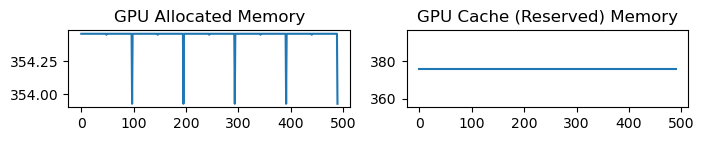

In [62]:
gpu_stats_cb = GPUStatsCb()
accuracy_cb = AccuracyCb()
learner_3 = Learner_3(model=model, optim=sgd_optim, dls=dls, loss_fn=ce_loss2, cbs=[gpu_stats_cb, accuracy_cb, ProgressCb_2(gpu_stats_cb, accuracy_cb)])
learner_3.fit(5)

# Iteration 8: Back Prop

In [63]:
x_train.shape, y_train.shape

(torch.Size([50000, 784]), torch.Size([50000]))

In [64]:
N = x_train.shape[0]
inp_dim = x_train.shape[1]
n_hidden = 12
n_classes = len(classes)

w1 = torch.rand(inp_dim, n_hidden).to(device) - 0.5
b1 = torch.rand(n_hidden).to(device) - 0.5

w2 = torch.rand(n_hidden, n_classes).to(device) - 0.5
b2 = torch.rand(n_classes).to(device) - 0.5

In [65]:
def lin(x, w, b): return x@w + b

In [66]:
l1 = lin(x_train, w1, b1)
l1.shape, (l1<0).float().sum()

(torch.Size([50000, 12]), tensor(282827., device='cuda:0'))

In [67]:
def relu(x): return x.clamp(min=0)

relu1 = relu(l1); (relu1<0).float().sum()

tensor(0., device='cuda:0')

In [68]:
w2.requires_grad_(), w1.requires_grad_(), b1.requires_grad_(), b2.requires_grad_()
y_oh = F.one_hot(y_train, n_classes)

In [69]:
# Forward pass
z1 = lin(x_train, w1, b1)
a1 = relu(z1)
z2 = lin(a1, w2, b2)
z2.shape

torch.Size([50000, 10])

In [70]:
def softmax(x): return x.exp() / x.exp().sum(1)[:, None]
def ce_loss(x): return -(x.log()*y_oh).sum(1)

In [71]:
# Softmax
a2 = softmax(z2)
a2.retain_grad()
loss = ce_loss(a2)
loss.shape, loss[:5]

(torch.Size([50000]),
 tensor([7.0436, 3.3352, 0.4626, 4.5841, 1.1992], device='cuda:0', grad_fn=<SliceBackward0>))

In [72]:
# Backward pass
loss.mean().backward()

In [84]:
# I want to know how loss changes when a2 (softmax) changes, so loss.backward() adds gradient to a2. 
def dL_dA2(a2): return -(y_oh/a2)/N
a2.g = dL_dA2(a2)
test_close(a2.g, a2.grad)
a2.g.shape, a2.shape, a2.grad.shape

(torch.Size([50000, 10]), torch.Size([50000, 10]), torch.Size([50000, 10]))

In [74]:
# Next, I want to know how loss changes when z2 changes. This step should add a gradient to z2
def dL_dZ2(z2):
    a2 = softmax()